In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile as wav
import os
import pandas as pd
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Reshape

In [90]:
def load_and_plot_audio(file_path):
    data, sr = librosa.load(file_path)
    ipd.Audio(file_path)
    
    plt.plot(data)
    plt.xlabel('Audio Signal')
    plt.ylabel('Amplitude')
    plt.show()


In [91]:
def load_wavfile(file_path):
    wavesr, wave_audio = wav.read(file_path)
    plt.plot(wave_audio)
    plt.show()
    return wavesr, wave_audio

In [92]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs.T, axis=0)
    return mfccs_scaled_features


In [93]:
def load_and_extract_features(folder_path):
    name_file = [file for file in os.listdir(folder_path) if file.endswith('.wav')]
    instruments = [name[:-6] for name in name_file]

    extracted_features = []
    for file_name in name_file:
        file_path = os.path.join(folder_path, file_name)
        features = extract_features(file_path)
        file_name = file_name.title()
        extracted_features.append([features, file_name[:-6]])

    return extracted_features, instruments

In [94]:
def prepare_data(extracted_features):
    df_features = pd.DataFrame(extracted_features, columns=['feature', 'class'])
    X = np.array(df_features['feature'].tolist())
    y = np.array(df_features['class'].tolist())
    
    le = LabelEncoder()
    ti = le.fit_transform(y)
    y = to_categorical(ti)
    
    return X, y, le

In [95]:
def build_model(input_shape, num_labels):
    model = Sequential()
    model.add(Reshape((input_shape[0], 1), input_shape=input_shape))
    model.add(Conv1D(32, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [96]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=30, batch_size=4):
    num_epochs = epochs
    num_batch_size = batch_size
    checkpointer = ModelCheckpoint(filepath='saved_model.hdf5', verbose=1, save_best_only=True)
    start = datetime.now()
    model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpointer])
    duration = datetime.now() - start
    print("Training completed in time: ", duration)

    test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test set accuracy: {test_accuracy[1] * 100}%")

    train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print(f"Train set accuracy: {train_accuracy[1] * 100}%")

In [97]:
def predict_class(model, file_path, le):
    x, sr = librosa.load(file_path)
    ipd.Audio(x, rate=sr)

    prediction_feature = extract_features(file_path)
    prediction_feature = prediction_feature.reshape(1, -1)
    predicted_probabilities = model.predict(prediction_feature)
    predicted_class_label = np.argmax(predicted_probabilities)
    predicted_class_label = np.array([predicted_class_label])
    prediction_class = le.inverse_transform(predicted_class_label)
    print("Predicted class:", prediction_class[0])

In [98]:
audio_file_path = "Music/Bhairavi01.wav"

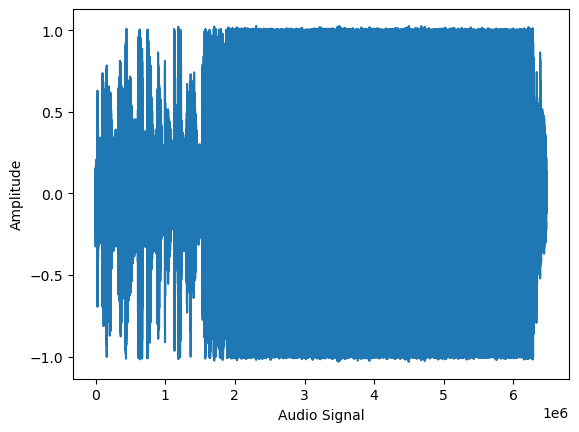

In [99]:
load_and_plot_audio(audio_file_path)

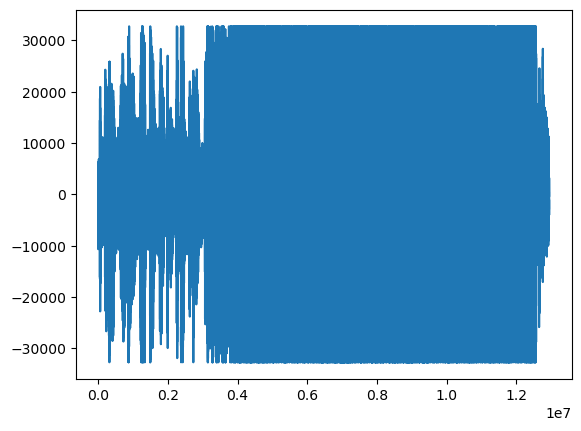

In [100]:
wavesr, wave_audio = load_wavfile(audio_file_path)

In [101]:
extracted_features, instruments = load_and_extract_features("Music")

In [102]:
X, y, label_encoder = prepare_data(extracted_features)

In [103]:
input_shape = (X.shape[1],)

In [104]:
num_labels = y.shape[1]

In [105]:
model = build_model(input_shape, num_labels)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=127)
train_model(model, X_train, y_train, X_test, y_test)

Epoch 1/30
16/17 [===========================>..] - ETA: 0s - loss: 3.4914 - accuracy: 0.1094   
Epoch 1: val_loss improved from inf to 2.02675, saving model to saved_model.hdf5
17/17 [==============================] - 3s 43ms/step - loss: 3.4507 - accuracy: 0.1231 - val_loss: 2.0267 - val_accuracy: 0.2353
Epoch 2/30
 8/17 [=============>................] - ETA: 0s - loss: 2.2928 - accuracy: 0.2188    

C:\Users\Anikait\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/17 [===========================>..] - ETA: 0s - loss: 2.0823 - accuracy: 0.2656
Epoch 2: val_loss improved from 2.02675 to 1.70027, saving model to saved_model.hdf5
17/17 [==============================] - 0s 18ms/step - loss: 2.0966 - accuracy: 0.2615 - val_loss: 1.7003 - val_accuracy: 0.4706
Epoch 3/30
16/17 [===========================>..] - ETA: 0s - loss: 1.3002 - accuracy: 0.5938
Epoch 3: val_loss improved from 1.70027 to 1.51439, saving model to saved_model.hdf5
17/17 [==============================] - 0s 18ms/step - loss: 1.3088 - accuracy: 0.5846 - val_loss: 1.5144 - val_accuracy: 0.5882
Epoch 4/30
16/17 [===========================>..] - ETA: 0s - loss: 1.2168 - accuracy: 0.6250
Epoch 4: val_loss improved from 1.51439 to 1.18165, saving model to saved_model.hdf5
17/17 [==============================] - 0s 19ms/step - loss: 1.1983 - accuracy: 0.6308 - val_loss: 1.1817 - val_accuracy: 0.5882
Epoch 5/30
16/17 [===========================>..] - ETA: 0s - loss: 0.9070 - accurac

Training completed in time:  0:00:09.951179
Test set accuracy: 88.23529481887817%
Train set accuracy: 100.0%


In [107]:
audio_to_predict = "Music/Bhairavi02.wav"

In [108]:
predict_class(model, audio_to_predict, label_encoder)

1/1 [==============================] - 0s 224ms/step
Predicted class: Bhairavi
